In [31]:
import os
import numpy as np
import pandas as pd
from sklearn import tree
import pydotplus
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import pickle

In [32]:
formants_folder = "all_formants_observed_formants_first_5_formants"
def load_formants_from_file(file_path):
    return pd.read_csv(file_path)


In [33]:
full_data = pd.DataFrame()
for formant_file in os.listdir(formants_folder):
    full_data = full_data.append(load_formants_from_file(os.path.join(formants_folder, formant_file)), ignore_index=True)



In [34]:
phoneme_remap = {
 'sil': 'sil',
 'g': 'plosive',
 'a': 'a',
 'f': 'fricative',
 's': 'fricative',
 'n': 'nasal',
 'r': 'voiceless',
 'j': 'approximant',
 'R': 'vibrant',
 'o': 'o',
 'b': 'plosive',
 'i': 'i',
 'k': 'plosive',
 'u': 'u',
 'd': 'plosive',
 'e': 'e',
 'l': 'approximant',
 'c': 'plosive',
 'm': 'nasal',
 't': 'plosive',
 'p': 'plosive',
 'y': 'fricative',
 'C': 'fricative',
 'N': 'nasal',
 '': 'voiced',
 'S': 'fricative'
}

full_data["phoneme"].replace(phoneme_remap, inplace=True)


In [35]:
sil_frames = full_data[full_data["phoneme"] == "sil"]

full_data = full_data.drop(sil_frames.index)


In [36]:
full_data['phoneme']
all_phonemes = [str(s) for s in full_data['phoneme'].unique()]


In [37]:
phonemes_grouped = full_data.groupby('phoneme')

phonemes_grouped.groups


{'a': [1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, ...], 'approximant': [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 9

In [38]:
phoneme_count = full_data['phoneme'].value_counts()
percentage_to_extract_test = 0.1
fixed_extra_to_test = 5

values_to_extract = (phoneme_count * percentage_to_extract_test + fixed_extra_to_test).round()
values_to_extract = values_to_extract.apply(np.int64)



In [39]:
train_set = full_data.dropna(subset=["phoneme"])
train_set[["i"]] = train_set[["i"]].fillna(value=-300)
test_set = pd.DataFrame()
for index, value in values_to_extract.items():
    sub_data_frame = train_set[train_set["phoneme"] == index]
    test_to_remove = sub_data_frame.sample(value)
    test_set = test_set.append(test_to_remove)
    train_set = train_set.drop(test_to_remove.index)

/home/ma0/miniconda3/envs/master_thesis/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [40]:
FORMANTS_TO_EXTRACT = 5
formant_names = [f"f_{i+1}" for i in range(FORMANTS_TO_EXTRACT)]
formant_names.append("i")
print(formant_names)


['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'i']


In [41]:
train_data = train_set[formant_names].fillna(train_set[formant_names].mean())

In [42]:
tree_classifier = tree.DecisionTreeClassifier(max_depth=6)
tree_classifier.fit(train_data, train_set['phoneme'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [43]:
test_data = test_set[formant_names].fillna(train_set[formant_names].mean())
predicted = tree_classifier.predict(test_data[formant_names])
score = accuracy_score(test_set["phoneme"], predicted)
score


0.5229759299781181

In [44]:
report = classification_report(test_set["phoneme"], predicted, labels=all_phonemes, digits=4)
print(report)

              precision    recall  f1-score   support

     vibrant     0.0000    0.0000    0.0000        29
           e     0.5349    0.5349    0.5349        86
 approximant     0.3623    0.3676    0.3650        68
           o     0.5294    0.7500    0.6207       144
           u     0.5625    0.2571    0.3529        35
       nasal     0.4359    0.4000    0.4172        85
   fricative     0.3853    0.4242    0.4038        99
     plosive     0.4077    0.4530    0.4291       117
   voiceless     0.0000    0.0000    0.0000        17
           a     0.7320    0.8068    0.7676       176
           i     0.6786    0.3276    0.4419        58
         nan     0.0000    0.0000    0.0000         0

   micro avg     0.5230    0.5230    0.5230       914
   macro avg     0.3857    0.3601    0.3611       914
weighted avg     0.5007    0.5230    0.5021       914



/home/ma0/miniconda3/envs/master_thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ma0/miniconda3/envs/master_thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
confusion = confusion_matrix(test_set["phoneme"], predicted, labels=all_phonemes)


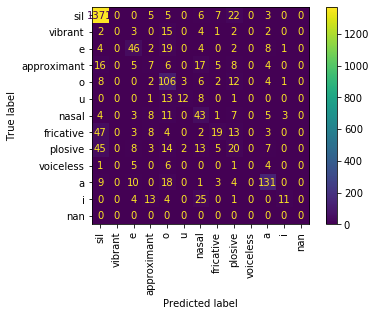

In [16]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion,
    display_labels=all_phonemes
)
disp.plot(
    # include_values=include_values,
    cmap='viridis',
    # ax=ax,
    xticks_rotation="vertical",
    values_format='g'
)

Results: 0.6159737417943107
Results with sil: 0.7565366480925847
F1 Macro: 0.349478263900204
F1 micro: 0.7569652807543935


In [19]:
f1_score(test_set["phoneme"], predicted, labels=all_phonemes, average='macro')

/home/ma0/miniconda3/envs/master_thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1514: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.349478263900204

In [20]:
f1_score(test_set["phoneme"], predicted, labels=all_phonemes, average='micro')

0.7569652807543935

              precision    recall  f1-score   support

         sil       0.91      0.96      0.94      1419
     vibrant       0.00      0.00      0.00        29
           e       0.59      0.50      0.54        86
 approximant       0.27      0.41      0.33        68
           o       0.45      0.74      0.56       144
           u       0.60      0.26      0.36        35
       nasal       0.41      0.42      0.42        85
   fricative       0.42      0.17      0.24        99
     plosive       0.22      0.21      0.21       117
   voiceless       0.00      0.00      0.00        17
           a       0.78      0.72      0.75       176
           i       0.56      0.16      0.24        58
         nan       0.00      0.00      0.00         0

   micro avg       0.76      0.76      0.76      2333
   macro avg       0.40      0.35      0.35      2333
weighted avg       0.74      0.76      0.74      2333



/home/ma0/miniconda3/envs/master_thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ma0/miniconda3/envs/master_thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
base_name = "consonant_types_with_sil"


tree.export_graphviz(
    tree_classifier,
    out_file=f'{base_name}.dot',
    feature_names=formant_names,
    class_names=all_phonemes,
    filled=True
)

print(tree.export_text(tree_classifier))

|--- feature_5 <= 59.46
|   |--- feature_5 <= 45.88
|   |   |--- feature_5 <= 38.36
|   |   |   |--- feature_1 <= 901.35
|   |   |   |   |--- class: o
|   |   |   |--- feature_1 >  901.35
|   |   |   |   |--- feature_5 <= 32.00
|   |   |   |   |   |--- feature_0 <= 330.23
|   |   |   |   |   |   |--- class: sil
|   |   |   |   |   |--- feature_0 >  330.23
|   |   |   |   |   |   |--- class: sil
|   |   |   |   |--- feature_5 >  32.00
|   |   |   |   |   |--- feature_4 <= 3830.42
|   |   |   |   |   |   |--- class: sil
|   |   |   |   |   |--- feature_4 >  3830.42
|   |   |   |   |   |   |--- class: sil
|   |   |--- feature_5 >  38.36
|   |   |   |--- feature_1 <= 1208.57
|   |   |   |   |--- feature_2 <= 2391.99
|   |   |   |   |   |--- feature_0 <= 381.79
|   |   |   |   |   |   |--- class: plosive
|   |   |   |   |   |--- feature_0 >  381.79
|   |   |   |   |   |   |--- class: sil
|   |   |   |   |--- feature_2 >  2391.99
|   |   |   |   |   |--- feature_0 <= 717.33
|   |   |   |   |

In [46]:

graph = pydotplus.graph_from_dot_file(f'{base_name}.dot')
print(type(graph))
with open(f"{base_name}.png", "wb+") as f:
    f.write(graph.create_png())

<class 'pydotplus.graphviz.Dot'>


In [47]:


with open(f"{base_name}.pickle", "wb+") as pickle_file:
    pickle.dump(tree_classifier, pickle_file)